# Applying ColumnTransformer to mixed column data types, and using pipelines

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

We could handle transformations directly when training the model. With ```ColumnTransform``` we can apply ```OneHotEncoder``` to categorical columns and ```RobustScaler``` (which is more robust to outliers than other transformations) to numerical columns. Let's go back to the original dataset to practice this.

In [14]:
import pandas as pd
import numpy as np

In [15]:
df = pd.read_csv('../data_prep/hot_plus_random.csv')

In [16]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,success
0,0.565,0.547,0.0,-7.722,1.0,0.0347,0.5790,0.000000,0.194,0.252,75.018,audio_features,1MOqMyQ7CULmWWjovkFY5B,spotify:track:1MOqMyQ7CULmWWjovkFY5B,https://api.spotify.com/v1/tracks/1MOqMyQ7CULm...,https://api.spotify.com/v1/audio-analysis/1MOq...,209320.0,4.0,1.0
1,0.578,0.894,10.0,-5.420,1.0,0.0296,0.0103,0.000003,0.216,0.741,165.980,audio_features,2dwhMQsFeHr2S787WxqAqW,spotify:track:2dwhMQsFeHr2S787WxqAqW,https://api.spotify.com/v1/tracks/2dwhMQsFeHr2...,https://api.spotify.com/v1/audio-analysis/2dwh...,347107.0,4.0,1.0
2,0.529,0.496,7.0,-9.007,1.0,0.0290,0.1730,0.000000,0.251,0.278,136.859,audio_features,3y4LxiYMgDl4RethdzpmNe,spotify:track:3y4LxiYMgDl4RethdzpmNe,https://api.spotify.com/v1/tracks/3y4LxiYMgDl4...,https://api.spotify.com/v1/audio-analysis/3y4L...,250547.0,4.0,1.0
3,0.488,0.923,2.0,-3.697,1.0,0.1030,0.1290,0.000000,0.158,0.818,183.891,audio_features,296XGtH5MeGisqD3uAz6Q6,spotify:track:296XGtH5MeGisqD3uAz6Q6,https://api.spotify.com/v1/tracks/296XGtH5MeGi...,https://api.spotify.com/v1/audio-analysis/296X...,202253.0,4.0,1.0
4,0.753,0.450,9.0,-6.909,1.0,0.0924,0.2740,0.000002,0.321,0.560,109.405,audio_features,6kD36kVRn5leDDbjXpHQY0,spotify:track:6kD36kVRn5leDDbjXpHQY0,https://api.spotify.com/v1/tracks/6kD36kVRn5le...,https://api.spotify.com/v1/audio-analysis/6kD3...,288933.0,4.0,1.0


In [17]:
df.shape

(15714, 19)

In [18]:
df.dtypes

danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms         float64
time_signature      float64
success             float64
dtype: object

In [19]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'success'],
      dtype='object')

# Logistic Regression

### Logistic Regression, GridSearchCV, StandardScaler and OneHotEncoder

Using pipelines with GridSearchCV
Reference: https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

AUC - Test Set: 94.58%


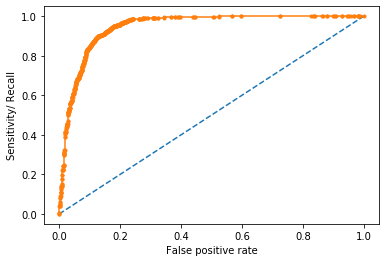

Logloss: 4.08
best params:  {'classifier__C': 100, 'classifier__max_iter': 100}
best score: 0.882
accuracy score: 0.882

               precision    recall  f1-score   support

         0.0       0.92      0.83      0.88      1587
         1.0       0.85      0.93      0.89      1556

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143

CPU times: user 1.39 s, sys: 56 ms, total: 1.44 s
Wall time: 3.63 s


In [54]:
%%time

# Removing outliers (only in training dataset to avoid data leakage)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.linear_model import LogisticRegression
from scipy import stats

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {'classifier__max_iter': [100, 500, 1000, 5000, 10000],
              'classifier__C': [0.01, 0.1, 1, 10, 100, 1000]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs=-1)

CV.fit(X_train, y_train)

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

### Overfitting

We need to check the accuracy difference between train and test set for each fold result. If our model gives us high training accuracy but low test accuracy, our model is overfitting. If our model does not give good training accuracy, we could say our model is underfitting.

To check whether the model we find by GridSearchCV is overfitted or not, we can use ```cv_results``` attribute of ```GridSearchCV```. ```cv_results``` is a dictionary which contains details (e.g. ```mean_test_score```, ```mean_score_time``` etc. ) for each combination of the parameters, given in parameters' grid. And to get training score related values (e.g. ```mean_train_score```, ```std_train_score``` etc.), we have to pass ```return_train_score = True``` which is by default false.

Then, comparing training and testing accuracy, we could ensure whether our model is overfitted or not. 

Train set mean accuracy 0.882
Test set mean accuracy 0.881


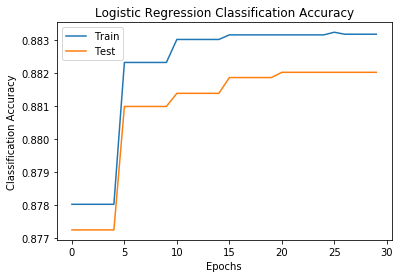

In [53]:
# Checking overfitting

print('Train set mean accuracy %.3f'% CV.cv_results_["mean_train_score"].mean())
print('Test set mean accuracy %.3f'% CV.cv_results_["mean_test_score"].mean())

# Plotting overfitting
results = CV.cv_results_
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('Logistic Regression Classification Accuracy')
plt.show()

# K-nearest neighbors Classifier

AUC - Test Set: 93.50%


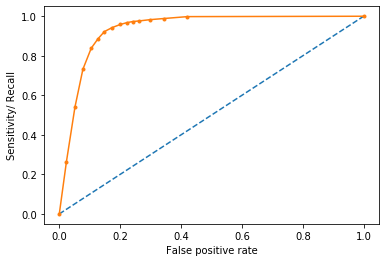

Logloss: 3.99
best params:  {'classifier__n_neighbors': 14}
best score: 0.878
accuracy score: 0.885
cross_val score: 0.879

               precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      1573
         1.0       0.84      0.94      0.89      1570

    accuracy                           0.88      3143
   macro avg       0.89      0.88      0.88      3143
weighted avg       0.89      0.88      0.88      3143

CPU times: user 6.28 s, sys: 358 ms, total: 6.64 s
Wall time: 49min 9s


In [55]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.neighbors import KNeighborsClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__n_neighbors': np.arange(4,100)}


CV = GridSearchCV(clf, 
                  param_grid,
                  return_train_score=True, 
                  n_jobs=-1)

CV.fit(X_train, y_train)


#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

Train set mean accuracy 0.876
Test set mean accuracy 0.871


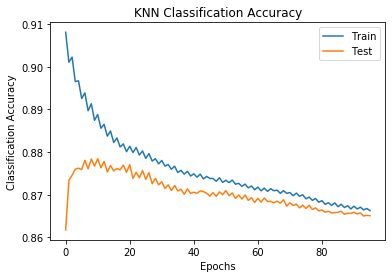

In [56]:
# Checking overfitting

print('Train set mean accuracy %.3f'% CV.cv_results_["mean_train_score"].mean())
print('Test set mean accuracy %.3f'% CV.cv_results_["mean_test_score"].mean())

# Plotting overfitting
results = CV.cv_results_
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('KNN Classification Accuracy')
plt.show()

# Support Vector Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

AUC - Test Set: 94.84%


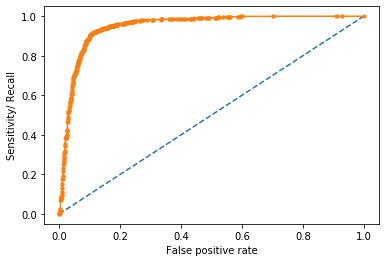

Logloss: 3.75
best params:  {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__probability': True, 'classifier__tol': 0.001}
best score: 0.891
accuracy score: 0.892

               precision    recall  f1-score   support

         0.0       0.94      0.84      0.89      1590
         1.0       0.85      0.94      0.90      1553

    accuracy                           0.89      3143
   macro avg       0.90      0.89      0.89      3143
weighted avg       0.90      0.89      0.89      3143

CPU times: user 14.9 s, sys: 424 ms, total: 15.4 s
Wall time: 1min 49s


In [57]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.svm import SVC

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__C': [.1, 1, 10, 100],
              'classifier__gamma': ['auto'],
              'classifier__tol': [.001],
              'classifier__probability': [True]
             }

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs=-1)

CV.fit(X_train, y_train)

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

Train set mean accuracy 0.910
Test set mean accuracy 0.885


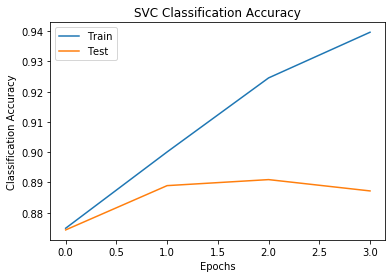

In [58]:
# Checking overfitting

print('Train set mean accuracy %.3f'% CV.cv_results_["mean_train_score"].mean())
print('Test set mean accuracy %.3f'% CV.cv_results_["mean_test_score"].mean())

# Plotting overfitting
results = CV.cv_results_
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('SVC Classification Accuracy')
plt.show()

# Decision Tree Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

AUC - Test Set: 93.02%


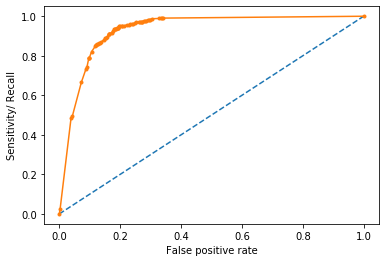

Logloss: 4.22
best params:  {'classifier__max_depth': 9, 'classifier__min_samples_leaf': 17}
best score: 0.881
accuracy score: 0.878

               precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1546
         1.0       0.84      0.93      0.89      1597

    accuracy                           0.88      3143
   macro avg       0.88      0.88      0.88      3143
weighted avg       0.88      0.88      0.88      3143

CPU times: user 38.1 s, sys: 2.05 s, total: 40.1 s
Wall time: 3min 6s


In [59]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.tree import DecisionTreeClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__max_depth': np.arange(2,20),
              'classifier__min_samples_leaf': np.arange(0,100)}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  return_train_score=True, 
                  n_jobs=-1)

CV.fit(X_train, y_train)

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
#print('cross_val score: %.3f' % cross_val_score(CV,X,y,cv=5,scoring='accuracy', n_jobs=-1).mean())
print('\n', classification_report(y_test,CV.predict(X_test)))

Train set mean accuracy 0.890
Test set mean accuracy 0.874


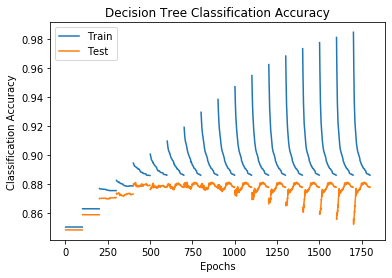

In [84]:
# Checking overfitting

# Removing nan's from results array

results = CV.cv_results_

# Removing nan's from results array
print('Train set mean accuracy %.3f'% \
      results["mean_train_score"][np.logical_not(np.isnan(results["mean_train_score"]))].mean())
print('Test set mean accuracy %.3f'% \
      results["mean_test_score"][np.logical_not(np.isnan(results["mean_test_score"]))].mean())

# Plotting overfitting
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('Decision Tree Classification Accuracy')
plt.show()

# Random Forest Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

AUC - Test Set: 95.20%


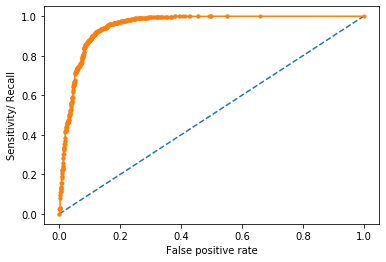

Logloss: 3.64
best params:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__n_estimators': 100, 'classifier__random_state': 0}
best score: 0.905
accuracy score: 0.895

               precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      1606
         1.0       0.86      0.94      0.90      1537

    accuracy                           0.89      3143
   macro avg       0.90      0.90      0.89      3143
weighted avg       0.90      0.89      0.89      3143

CPU times: user 6.52 s, sys: 313 ms, total: 6.84 s
Wall time: 5min 37s


In [85]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__n_estimators': [50, 100, 150, 200, 250],
              'classifier__max_features': ['auto', 'sqrt', 'log2'],
              'classifier__max_depth': [10, 15, 20, 25, 30],
              'classifier__criterion': ['gini', 'entropy'],
              'classifier__random_state': [0]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs=-1)

CV.fit(X_train, y_train)

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

Train set mean accuracy 0.970
Test set mean accuracy 0.901


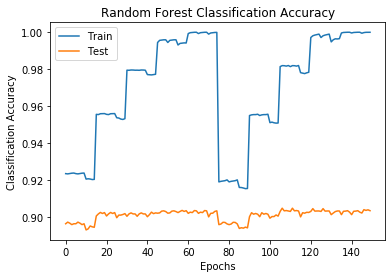

In [86]:
# Checking overfitting

print('Train set mean accuracy %.3f'% CV.cv_results_["mean_train_score"].mean())
print('Test set mean accuracy %.3f'% CV.cv_results_["mean_test_score"].mean())

# Plotting overfitting
results = CV.cv_results_
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('Random Forest Classification Accuracy')
plt.show()

# XGBoost Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV

As sklearn pipelines remove feature names, we add some coding for storing the names of the features for evaluating feature importance later. 

AUC - Test Set: 96.33%


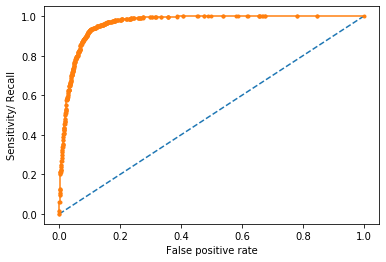

Logloss: 3.13
best params:  {'classifier__colsample_bytree': 1, 'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
best score: 0.903
accuracy score: 0.909

               precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      1543
         1.0       0.88      0.95      0.91      1600

    accuracy                           0.91      3143
   macro avg       0.91      0.91      0.91      3143
weighted avg       0.91      0.91      0.91      3143

CPU times: user 20.6 s, sys: 76.5 ms, total: 20.7 s
Wall time: 6min 39s


In [87]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from xgboost.sklearn import XGBClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  return_train_score = True,
                  n_jobs=-1)

CV.fit(X_train, y_train)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

In [88]:
print(CV.best_estimator_.named_steps['classifier'].feature_importances_)

[0.02142083 0.02506055 0.4020271  0.03643012 0.03408125 0.07329585
 0.04851101 0.03459535 0.01380936 0.05409023 0.01203117 0.01288325
 0.01342407 0.01590185 0.01561082 0.01364684 0.01302921 0.01397239
 0.01101681 0.01443472 0.010671   0.02169384 0.00663569 0.02699864
 0.04025509 0.0144729 ]


In [89]:
print(CV.best_estimator_.named_steps['classifier'].get_booster().get_fscore())

{'f2': 2183, 'f0': 1691, 'f3': 2362, 'f6': 1787, 'f5': 1563, 'f1': 1627, 'f9': 2176, 'f4': 1768, 'f10': 175, 'f8': 1445, 'f7': 1925, 'f17': 71, 'f15': 53, 'f11': 37, 'f24': 148, 'f21': 207, 'f16': 67, 'f18': 41, 'f19': 54, 'f23': 65, 'f20': 29, 'f14': 64, 'f13': 43, 'f22': 15, 'f12': 7, 'f25': 4}


In [90]:
df_from_array_pipeline

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,mode_1.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,0.495370,0.151927,0.028733,0.848592,-0.043373,0.011134,-0.267368,0.875676,-0.370596,0.242923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.689815,-0.337868,0.180468,-0.124648,0.565579,0.000000,0.542105,-0.886486,-1.072351,1.073832,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.032407,0.682540,0.494915,0.890845,-0.213393,0.000000,1.005263,-0.132432,-0.384812,1.014481,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.300926,-0.331066,-0.605973,3.095070,0.497918,0.000000,1.005263,-0.316216,-0.081282,-1.273507,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.064815,0.476190,0.231907,1.098592,-0.107564,0.000000,0.115789,0.608108,0.904238,-0.425116,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12566,1.125000,0.133787,0.404089,0.742958,-0.121443,0.000000,0.473684,1.286486,-0.681463,0.142786,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
12567,0.694444,-0.092971,-0.094054,-0.143310,0.111034,0.000000,0.915789,1.208108,-0.565673,-0.101828,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12568,0.601852,0.247166,0.023460,-0.083803,-0.187370,0.000000,0.521053,1.113514,-0.704323,0.065493,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12569,0.638889,-0.965986,-0.911811,3.031690,0.237682,0.000000,1.142105,0.213514,-1.450056,-1.950760,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [91]:
print(feature_importance.sort_values(ascending=False))

loudness              0.402027
instrumentalness      0.073296
duration_ms           0.054090
liveness              0.048511
time_signature_4.0    0.040255
speechiness           0.036430
valence               0.034595
acousticness          0.034081
time_signature_3.0    0.026999
energy                0.025061
mode_1.0              0.021694
danceability          0.021421
key_4.0               0.015902
key_5.0               0.015611
time_signature_5.0    0.014473
key_10.0              0.014435
key_8.0               0.013972
tempo                 0.013809
key_6.0               0.013647
key_3.0               0.013424
key_7.0               0.013029
key_2.0               0.012883
key_1.0               0.012031
key_9.0               0.011017
key_11.0              0.010671
time_signature_1.0    0.006636
dtype: float32


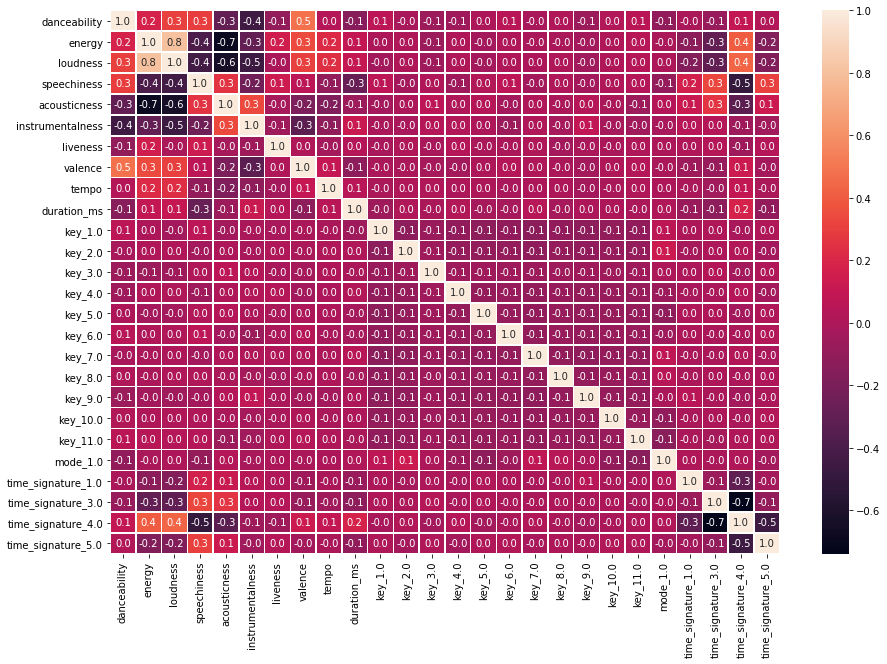

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_from_array_pipeline.corr()
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f', ax=ax);

Train set mean accuracy 0.943
Test set mean accuracy 0.899


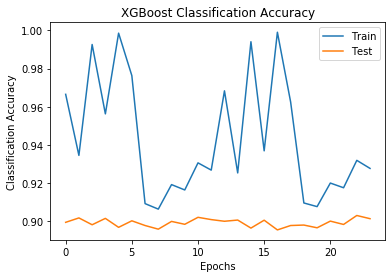

In [93]:
# Checking overfitting

print('Train set mean accuracy %.3f'% CV.cv_results_["mean_train_score"].mean())
print('Test set mean accuracy %.3f'% CV.cv_results_["mean_test_score"].mean())

# Plotting overfitting
results = CV.cv_results_
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Accuracy')
plt.show()

# XGBoost Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV
Dropping 'energy' as it shows correlation with 'loudness'

AUC - Test Set: 95.53%


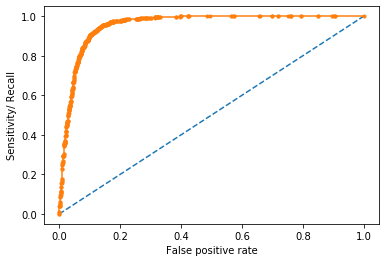

Logloss: 3.26
best params:  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
best score: 0.902
accuracy score: 0.906

               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      1552
         1.0       0.88      0.95      0.91      1591

    accuracy                           0.91      3143
   macro avg       0.91      0.90      0.91      3143
weighted avg       0.91      0.91      0.91      3143

CPU times: user 18.5 s, sys: 109 ms, total: 18.6 s
Wall time: 6min 30s


In [95]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from xgboost.sklearn import XGBClassifier

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success', 'energy'], axis=1)
y = df['success']
numeric_features = ['danceability', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  return_train_score=True, 
                  n_jobs=-1)

CV.fit(X_train, y_train)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

It seems that dropping 'energy' **does not seem** to have improved the metrics. On the contrary, metrics seems worse.

Train set mean accuracy 0.942
Test set mean accuracy 0.899


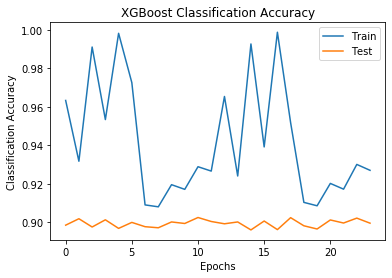

In [96]:
# Checking overfitting

print('Train set mean accuracy %.3f'% CV.cv_results_["mean_train_score"].mean())
print('Test set mean accuracy %.3f'% CV.cv_results_["mean_test_score"].mean())

# Plotting overfitting
results = CV.cv_results_
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Accuracy')
plt.show()

# XGBoost Classifier
### RobustScaler, OneHotEncoder, Pipeline and GridSearchCV, removing outliers 

Now we'll try to improve the metrics by **removing the outliers in the training dataset** (only in the training dataset to avoid data leakage). Let's also switch to StandardScaler.

train shape:  (12571, 13) (12571,)
train shape after cleaning:  (11919, 13) (11919,)
AUC - Test Set: 95.35%


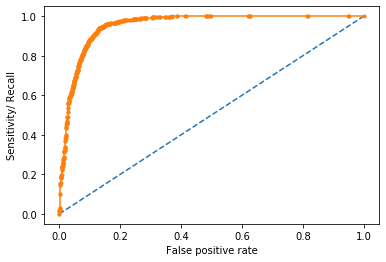

Logloss: 3.37
best params:  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'classifier__subsample': 0.8}
best score: 0.903
accuracy score: 0.902

               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1561
         1.0       0.87      0.95      0.91      1582

    accuracy                           0.90      3143
   macro avg       0.91      0.90      0.90      3143
weighted avg       0.91      0.90      0.90      3143

CPU times: user 17.5 s, sys: 73 ms, total: 17.5 s
Wall time: 6min 38s


In [98]:
%%time

# Removing outliers (only in training dataset to avoid data leakage)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss
from xgboost.sklearn import XGBClassifier
from scipy import stats

X = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'success'], axis=1)
y = df['success']
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['key', 'mode', 'time_signature']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

######### REMOVE OUTLIERS IN TRAINING DATASET #####################

print('train shape: ', X_train.shape, y_train.shape)

idx = np.all(stats.zscore(X_train) < 3, axis=1)

X_train_cleaned = X_train.loc[idx]
y_train_cleaned = y_train.loc[idx]

print('train shape after cleaning: ', X_train_cleaned.shape, y_train_cleaned.shape)

###################################################################

param_grid = {'classifier__learning_rate': [0.1, 0.01],
              'classifier__n_estimators': [1000],
              'classifier__max_depth': [3, 4, 5],
              'classifier__subsample': [0.8, 1],
              'classifier__colsample_bytree': [0.8, 1],
              'classifier__gamma': [1]}

CV = GridSearchCV(clf, 
                  param_grid,
                  scoring='accuracy',
                  return_train_score=True,
                  n_jobs=-1)

CV.fit(X_train_cleaned, y_train_cleaned)

########## EXTRACT FEATURE NAMES ##################

onehot_columns = CV.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names(input_features=categorical_features)

#you can get the values transformed with your pipeline
X_values = preprocessor.fit_transform(X_train)

df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.Series(data= CV.best_estimator_.named_steps['classifier']\
                                .feature_importances_, index = np.array(numeric_features + list(onehot_columns)))

##################################################

#predict probabilities
probs = CV.predict_proba(X_test)
#predict probabilities for the positive outcome only
probs = probs[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show();

# predict and compute logloss
pred = CV.predict(X_test)
accuracy = log_loss(y_test, pred)
print('Logloss: %.2f' % (accuracy))

print('best params: ', CV.best_params_)    
print('best score: %.3f' % CV.best_score_)

print('accuracy score: %.3f' % CV.score(X_test, y_test))
print('\n', classification_report(y_test,CV.predict(X_test)))

Train set mean accuracy 0.945
Test set mean accuracy 0.900


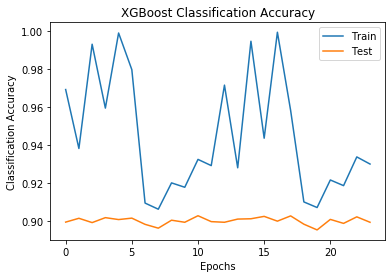

In [100]:
# Checking overfitting

print('Train set mean accuracy %.3f'% CV.cv_results_["mean_train_score"].mean())
print('Test set mean accuracy %.3f'% CV.cv_results_["mean_test_score"].mean())

# Plotting overfitting
results = CV.cv_results_
epochs = len(results["mean_train_score"])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results["mean_train_score"], label='Train')
ax.plot(x_axis, results["mean_test_score"], label='Test')
ax.legend()
plt.ylabel('Classification Accuracy')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Accuracy')
plt.show()

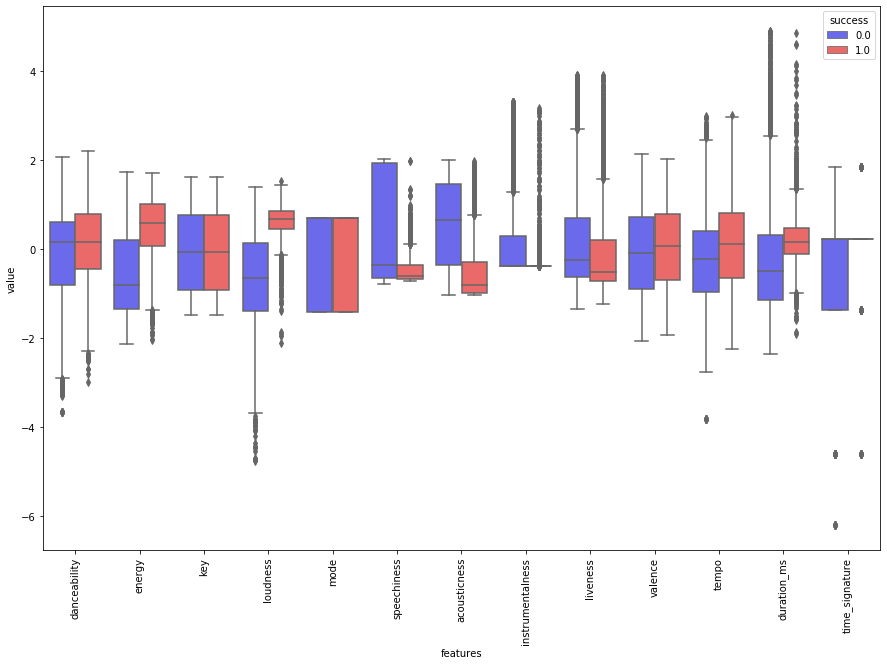

In [101]:
# Boxplot after removing the outliers

data_dia = y_train_cleaned
data = X_train_cleaned
data_n_2 = (data - data.mean()) / (data.std())      # standardization and unpivot for violin and box plots
data = pd.concat([y,data_n_2.iloc[:,0:13]],axis=1)
data = pd.melt(data,id_vars="success",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(15,10))
#ax = sns.violinplot(x="features", y="value", hue="success", data=data,split=True, inner="quart", palette='seismic')
ax = sns.boxplot(x="features", y="value", hue="success", data=data, palette='seismic')
plt.xticks(rotation=90);

### Saving the model

In [ ]:
import pickle
pickle.dump(CV ,open("model.pkl","wb"))